# Sentiment Analysis

In [16]:
import pandas as pd
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import transformers
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from itertools import chain
from nltk import NaiveBayesClassifier

### Load data

In [ ]:
data = pd.read_csv("../data/book_reviews_sample.csv") # the data should be in the same folder as your notebook
data.head()

,index,reviewText,rating
0,11494,Clean and funny. A bit busy with all the diffe...,3
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4
2,1463,Good thing that this is a free story. I read i...,1
3,10342,"Action, action, action! Equipment keeps gettin...",4
4,5256,this was hands down the worse book i have ever...,1


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       100 non-null    int64 
 1   reviewText  100 non-null    object
 2   rating      100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [19]:
data['reviewText'][0]

'Clean and funny. A bit busy with all the different plots going on. But overall a good read. Bye now.'

### Clean data

In [20]:
# lowercase
data['reviewText_clean'] = data['reviewText'].str.lower()

In [21]:
# remove punctuation
data['reviewText_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['reviewText_clean']), axis=1)

In [22]:
data.head()

,index,reviewText,rating,reviewText_clean
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...


### Rule-based sentiment with VADER

In [23]:
vader_sentiment = SentimentIntensityAnalyzer()

In [24]:
data['vader_sentiment_score'] = data['reviewText_clean'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])
data.head()

,index,reviewText,rating,reviewText_clean,vader_sentiment_score
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...,0.7684
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...,0.9325
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...,0.6740
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...,0.6652
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...,-0.4767


In [25]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)
data.head()

,index,reviewText,rating,reviewText_clean,vader_sentiment_score,vader_sentiment_label
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...,0.7684,positive
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...,0.9325,positive
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...,0.6740,positive
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...,0.6652,positive
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...,-0.4767,negative


<Axes: xlabel='vader_sentiment_label'>

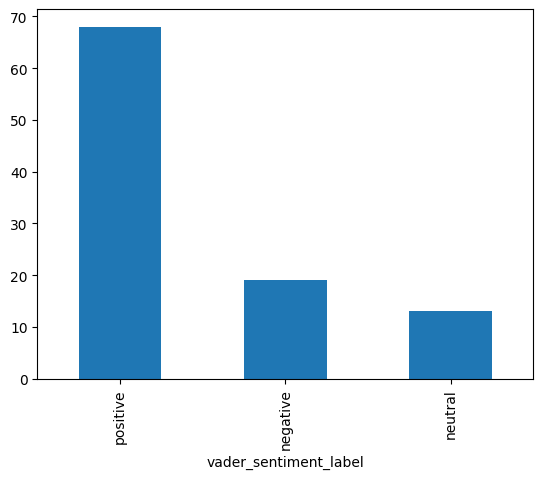

In [26]:
data['vader_sentiment_label'].value_counts().plot.bar()

### Pre-trained Transformer Model

In [27]:
transformer_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: b6538011-25b4-4b0b-9d55-da9c2f5ee7e6)')' thrown while requesting HEAD https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english/resolve/714eb0f/config.json
Retrying in 1s [Retry 1/5].
Device set to use mps:0


In [28]:
transformer_labels = []

for review in data['reviewText_clean'].values:
    sentiment_list = transformer_pipeline(review)
    sentiment_label = [sent['label'] for sent in sentiment_list]
    transformer_labels.append(sentiment_label)
    
data['transformer_sentiment_label'] = transformer_labels
data.head()

,index,reviewText,rating,reviewText_clean,vader_sentiment_score,vader_sentiment_label,transformer_sentiment_label
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...,0.7684,positive,[POSITIVE]
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...,0.9325,positive,[POSITIVE]
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...,0.6740,positive,[NEGATIVE]
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...,0.6652,positive,[NEGATIVE]
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...,-0.4767,negative,[NEGATIVE]


<Axes: xlabel='transformer_sentiment_label'>

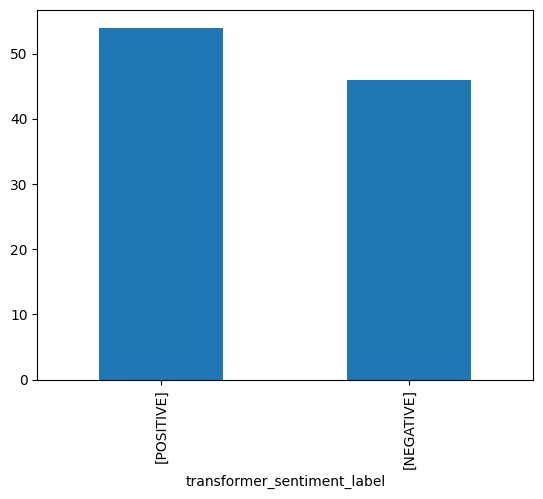

In [29]:
data['transformer_sentiment_label'].value_counts().plot.bar()

### Pre-trained Specific Transformer Model (finiteautomata/bertweet-base-sentiment-analysis)

In [30]:
specific_model = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use mps:0


In [31]:
specific_transformer_labels = []

for review in data['reviewText_clean'].values:
    sentiment_list = specific_model(review)
    sentiment_label = [sent['label'] for sent in sentiment_list]
    specific_transformer_labels.append(sentiment_label)
    
data['specific_transformer_sentiment_label'] = specific_transformer_labels
data.head()

,index,reviewText,rating,reviewText_clean,vader_sentiment_score,vader_sentiment_label,transformer_sentiment_label,specific_transformer_sentiment_label
0,11494,Clean and funny. A bit busy with all the diffe...,3,clean and funny a bit busy with all the differ...,0.7684,positive,[POSITIVE],[POS]
1,984,Alex a sexy hot cop and the PhD candidate. Wha...,4,alex a sexy hot cop and the phd candidate what...,0.9325,positive,[POSITIVE],[POS]
2,1463,Good thing that this is a free story. I read i...,1,good thing that this is a free story i read it...,0.6740,positive,[NEGATIVE],[NEG]
3,10342,"Action, action, action! Equipment keeps gettin...",4,action action action equipment keeps getting b...,0.6652,positive,[NEGATIVE],[NEG]
4,5256,this was hands down the worse book i have ever...,1,this was hands down the worse book i have ever...,-0.4767,negative,[NEGATIVE],[NEG]


<Axes: xlabel='specific_transformer_sentiment_label'>

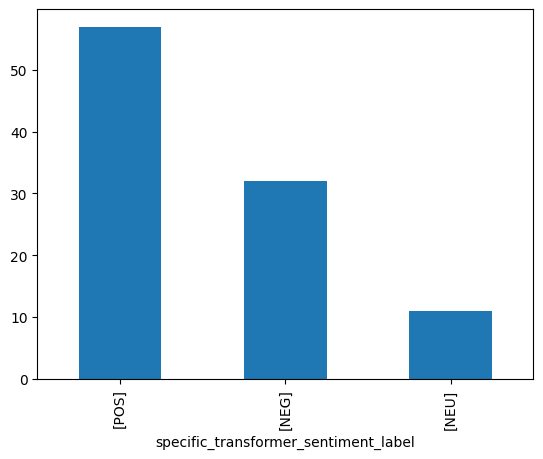

In [32]:
data['specific_transformer_sentiment_label'].value_counts().plot.bar()